## Importing the relevant packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [49]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [50]:
df_comp['market_value']=df_comp.ftse

In [51]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The LLR Test

In [52]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [53]:
import warnings
warnings.filterwarnings("ignore")

## Creating Returns

In [54]:
df['returns'] = df.market_value.pct_change(1)*100

## ACF for Returns

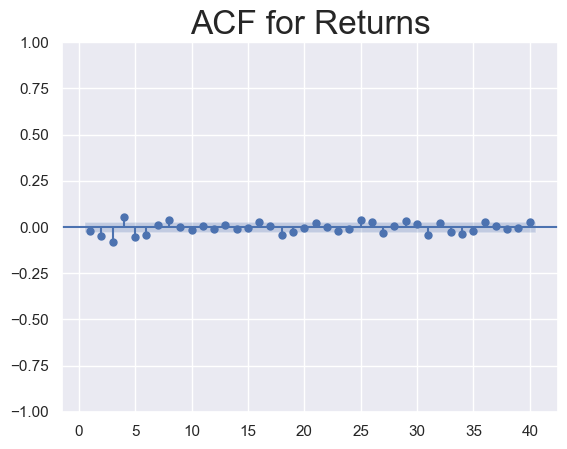

In [55]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

## MA(1) for Returns

In [56]:
from statsmodels.tsa.arima.model import ARIMA

In [57]:
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0,0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Thu, 12 Oct 2023   AIC                          15865.190
Time:                        12:40:25   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag MA Models for Returns

In [58]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Thu, 12 Oct 2023   AIC                          15853.728
Time:                        12:40:26   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.0

In [59]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Thu, 12 Oct 2023   AIC                          15818.634
Time:                        12:40:29   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.0

In [60]:
model_ret_ma_4 = ARIMA(df.returns[1:], order=[0,0,4])
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7898.773
Date:                Thu, 12 Oct 2023   AIC                          15809.547
Time:                        12:40:34   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0203      0.009     -2.239      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.835      0.0

In [61]:
model_ret_ma_5 = ARIMA(df.returns[1:], order=[0,0,5])
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7892.823
Date:                Thu, 12 Oct 2023   AIC                          15799.645
Time:                        12:40:38   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0262      0.009     -2.839      0.005      -0.044      -0.008
ma.L2         -0.0497      0.008     -6.147      0.0

In [62]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=[0,0,6])
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Thu, 12 Oct 2023   AIC                          15794.442
Time:                        12:40:44   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

In [63]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=[0,0,7])
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Thu, 12 Oct 2023   AIC                          15796.091
Time:                        12:40:52   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.0

In [64]:
model_ret_ma_8 = ARIMA(df.returns[1:], order=[0,0,8])
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Thu, 12 Oct 2023   AIC                          15791.205
Time:                        12:41:02   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.0

In [65]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF = 2)

0.027

## Residuals for Returns

In [66]:
df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [67]:
print("The mean of the residuals is " + str(round(df.res_ret_ma_8.mean(),3)) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is -0.0
The variance of the residuals is 1.356


In [68]:
round(sqrt(df.res_ret_ma_8.var()),3)

1.164

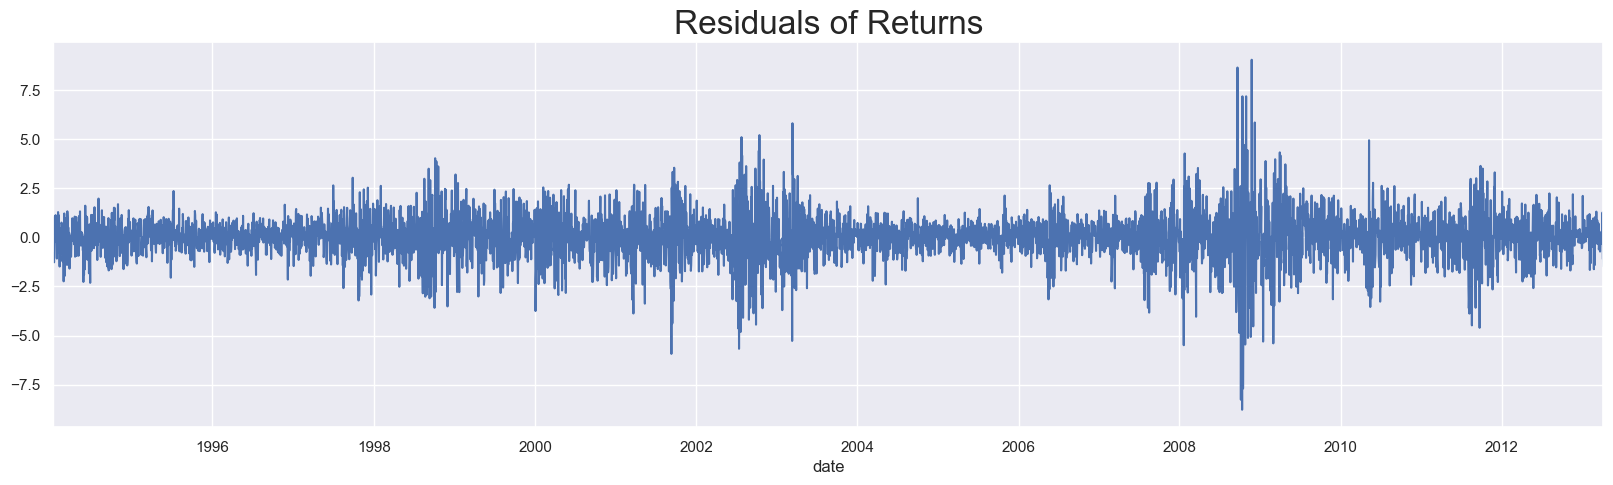

In [69]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [70]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83537125699189,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.05221738934)

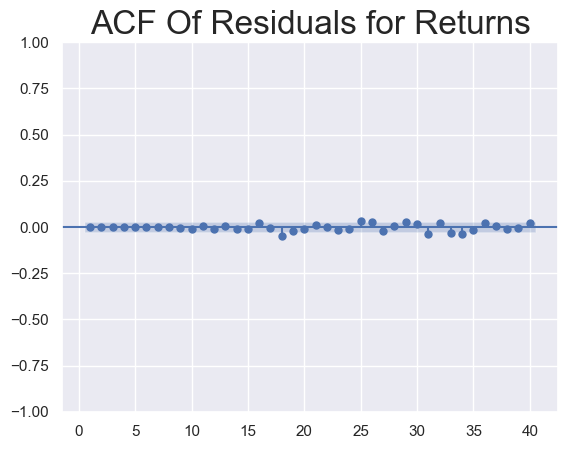

In [71]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Normalized Returns

In [29]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

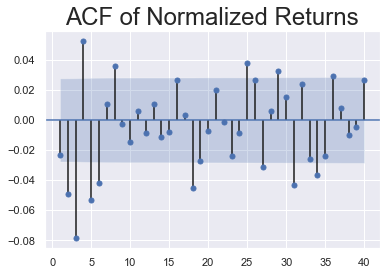

In [30]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

In [31]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Sat, 07 Sep 2019   AIC                          80635.194
Time:                        16:17:35   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -12.0369      8.846     -1.361      0.174     -29.374       5.301
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [32]:
df['res_norm_ret_ma_8'] = results_ret_ma_8.resid[1:]

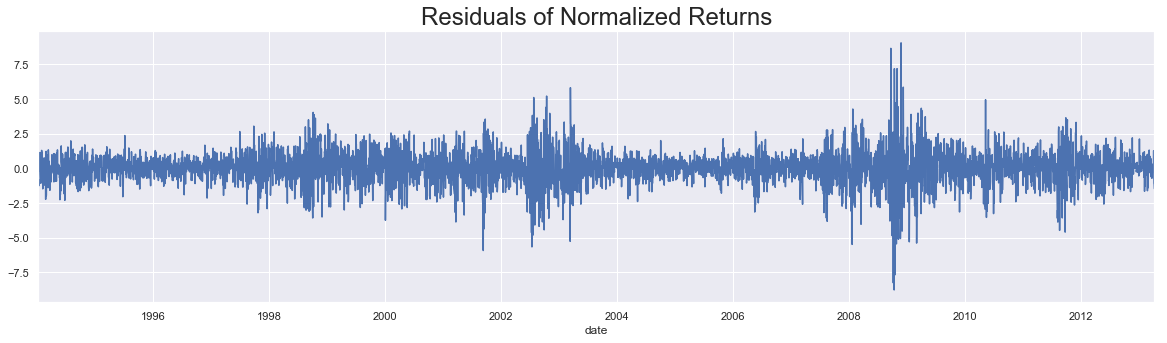

In [33]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()

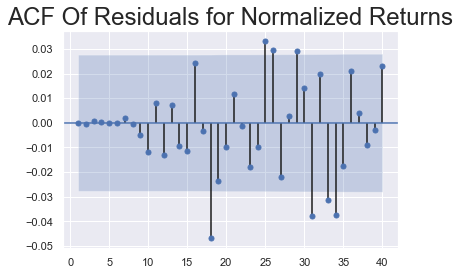

In [34]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

## MA Models For Prices

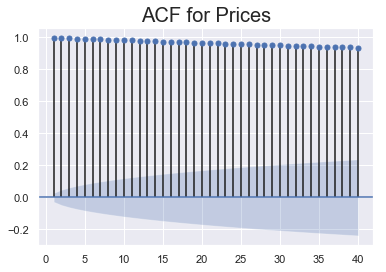

In [40]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

In [41]:
model_ma_1 = ARMA(df.market_value, order=(0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Sat, 07 Sep 2019   AIC                          77264.000
Time:                        16:25:01   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6144     14.660    347.188      0.000    5060.882    5118.347
ma.L1.market_value     0.9573      0.003    335.559      0.000       0.952       0.963
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0446           +0.0000j            1.0446            0.5000
-----------------------------------------------------------------------------
"""